#Preamble

This mini-project involves working through all the steps of a problem, whereas prior assignments asked you to just implement core functions. We will give you a dataset, but you will also have the opportunity to manipulate the data in ways that you find beneficial to the overall project and to explain why and how those manipulations mattered. This will be in addition to building the model from scratch, developing the training loop, and implementing testing. The code will be accompanied by a report written into the notebook.

This project will have you working with attention mechanism, in a new type of system for question-answering. This will provide you with experience working with attention mechanisms while not directly working with transformers.

This assignment is not autograded. You can modify any code cells as long as you achieve the requirements of each graded component.

# Introduction

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment and learn about self-attention without the added complexity of transformers.

Key-value memory networks are also closely related to retieval-based generation networks, except we will be retrieving facts from a dictionary instead of via the internet. However, the embedding of retrieved data will be similar.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126). It is recommended that you read the paper, but we will also walk through the steps you will need to complete.

# Some imports



You may add imports as necessary.

In [1]:
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(device)

mps


Unidecode is useful for getting rid of issues that arise from unicode. This should not be used if we care about unicode, but for the purposes of an instructional exercise, it eliminates a lot of edge cases that come up with unicode.

In [3]:
!pip install unidecode

In [3]:
import unidecode

If you need to have a reduced vocabulary, you can create an unknown "unk" token and add it to the vocabulary. Make sure the token index in the vocabulary and `UNK_ID` match.

In [4]:
UNK = 'unk'
UNK_ID = '0'

# Some utilities

You may edit these as necessary.

Stem words

In [5]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [6]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

A standard vocabulary object class

In [7]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words from a sentence, given a vocabulary. Can return a bag of word counts or a bag of word presences.

In [8]:
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return mhot.sum(0)
  else:
    return mhot.sum(0) >= 1


If you have a reduced vocabulary, use this to replace out-of-vocab words. If you use this, you may want to merge it with `multihot` above to avoid tokenizing twice.

In [9]:
def unkit(s, vocab):
  return ' '.join(list(map(lambda x: UNK if x not in vocab._word2index else x, tokenize(s))))

# Part A: Download and Process Data (0 points)

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [9]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

Cloning into 'wikipedia-biography-dataset'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93 (from 1)
Receiving objects: 100% (93/93), 338.68 MiB | 44.66 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [10]:
!cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
!unzip -o tmp.zip
!rm tmp.zip

Archive:  tmp.zip
   creating: wikipedia-biography-dataset/test/
  inflating: wikipedia-biography-dataset/test/test.box  
  inflating: wikipedia-biography-dataset/test/test.id  
  inflating: wikipedia-biography-dataset/test/test.nb  
  inflating: wikipedia-biography-dataset/test/test.sent  
  inflating: wikipedia-biography-dataset/test/test.url  
  inflating: wikipedia-biography-dataset/test/test.contributors  
  inflating: wikipedia-biography-dataset/test/test.title  
   creating: wikipedia-biography-dataset/train/
  inflating: wikipedia-biography-dataset/train/train.box  
  inflating: wikipedia-biography-dataset/train/train.id  
  inflating: wikipedia-biography-dataset/train/train.nb  
  inflating: wikipedia-biography-dataset/train/train.sent  
  inflating: wikipedia-biography-dataset/train/train.url  
  inflating: wikipedia-biography-dataset/train/train.contributors  
  inflating: wikipedia-biography-dataset/train/train.title  
   creating: wikipedia-biography-dataset/valid/
  infla

Get all the wikipedia titles.

In [10]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r") as file:
  for line in file:
    train_titles.append(line.rstrip())

Boxes contain all the information, with each line corresponding to a title in `titles`.

In [11]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
  for line in file:
    train_boxes.append(line.rstrip())

This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [12]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [13]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  return vocab

If you want to discard rare words, this will rebuild the vocab. This is just an example.

In [14]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [123]:
DB = make_db(train_titles, train_boxes)

100%|██████████| 582659/582659 [00:37<00:00, 15558.86it/s]


Make the VOCAB

In [124]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

100%|██████████| 2997937/2997937 [00:01<00:00, 2660700.81it/s]

96093


## Save Processed Data

You may find it useful to save the processed dataset to your Google Drive.

It is recommended that you save the file to your Google Drive. To mount your Google Drive, open the file icon on the left side of the screen to get to the option). To save the file in your Google Drive use the path `'drive/MyDrive/filename'`.)

Otherwise, save the file locally. Make sure to save it in the same directory as this notebook. Use the command `!ls` to see what files are in your current directory.

In [15]:
MY_DRIVE = "LOCAL" # Set this to "GOOGLE" if saving to Google Drive
path = 'drive/MyDrive/' if MY_DRIVE == "GOOGLE" else ''

if MY_DRIVE == "GOOGLE":
    from google.colab import drive
    drive.mount('/content/drive')

In [16]:
def save_data(path, data, name="data"):
    with open(f"{path}{name}", "wb") as f:
        pickle.dump(data, f, protocol=None, fix_imports=True, buffer_callback=None)

In [ ]:
# Save the vocab and DB
save_data(path, VOCAB, name="vocab")
save_data(path, DB, name="data")

## Load processed data

If you have saved the processed data in your Google Drive (or locally), you can re-load it with these commands.

In [18]:
def load_data(path, name="data"):
    with open(f"{path}{name}", "rb") as f:
        data = pickle.load(f)
    return data

In [19]:
VOCAB = load_data(path, name="vocab")
DB = load_data(path, name="data")

## Data example

Get to know your data.

In [20]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Part B: Implement the Key-Value Memory Network (10 points)

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this assignment is is sufficient to only do *single-hop* retrieval.

The above explanation does not include consideration of batching. You may want to add a batch dimension as the first dimension and input a batch as a set of questions, a set of stacks of keys, and a set of stacks of values. To do this, functions like `.inner()`, `.mm()`, and`.matmul()` will not work. Instead use `.bmm()` which handles batching correctly. You will probably need to do some `.squeeze()` and `.unsqueeze()` operations to make sure your tensors are the correct shapes.

Instead of bag-of-words, one may also consider first converting each question, key, and value into a general set of embeddings such as [GLoVe](https://nlp.stanford.edu/projects/glove/). To do this one will need to consider how to combine words--convert each word into an embedding vector and then add the vectors together (or maybe average them).

**Complete the key-value memory net code**

In [21]:
def get_batch(data, idx, batch_size):
  end_idx = min(idx + batch_size, data.shape[0])
  return data[idx:end_idx]

In [22]:
class KVMemNet(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(KVMemNet, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    
    ### YOUR CODE HERE
    self.A = nn.Linear(vocab_size, embed_dim, bias=False).to(device)
    self.B = nn.Linear(vocab_size, embed_dim, bias=False).to(device)

  def forward(self, x, keys, values):
    ### YOUR CODE BELOW
    
    # Assume batched data
    # x:      (vocab_size,)             --->   (batch_size, vocab_size)
    # keys:   (num_keys, vocab_size)    --->   (batch_size, num_keys, vocab_size)
    # values: (num_values, vocab_size)  --->   (batch_size, num_values, vocab_size)
    
    # Embeddings
    q = self.A(x)       # (batch_size, embed_dim)
    k = self.A(keys)    # (batch_size, num_keys, embed_dim)
    v = self.A(values)  # (batch_size, num_values, embed_dim)
    
    # Attention scores: k⋅q = (batch, num_keys, embed_dim) x (batch, embed_dim, 1)
    scores = torch.bmm(k, q.unsqueeze(2))   # (batch_size, num_keys, 1)
    scores = scores.squeeze(2)              # (batch_size, num_keys)

    # Attention weights
    p = F.softmax(scores, dim=1)            # (batch, num_keys)
    
    # Weighted sum of values: p⋅v = (batch, num_keys) x (batch, num_values, embed_dim)
    output = torch.bmm(p.unsqueeze(1), v)    # (batch, 1, embed_dim)
    output = output.squeeze(1)                    # (batch, embed_dim)
    
    ### YOUR CODE ABOVE
    return output


# Synthetic Data Set

This is a synthetic dataset. One way to test a model during development is to take a small piece of data and show that you can overfit a model. If you can't overfit an easily learned chunk of data, then you probably have something wrong in your code. In this case I have provided a small chunk of synthetic data that should be easy to learn.

- The vocabulary is 20 word: 5 names, 5 relations, 5 question-words, 5 values
 - First 5 elements of the vocab are names (for example index 0 might be "Hamilton").
 - Second 5 elements of the vocab are relations (for example, "born", "died", "occupation").
 - Third 5 elements are random words that might be part of a query (for example, "When was").
 - Final 5 elements of the vocab are possible values (for example, "1757")
- A "question" is a name (5, 1), relation (5, 1), some words (5, 1), and no values
- The keys will all have the same name (5, 5) where each row is idential, relations (5, 5), no words, no values
- Values will have no names, no relations, no words, and value vocab words

In [23]:
# Turn on a different relation on each row
relations = torch.zeros(5, 5)
relations.fill_diagonal_(1)

# training data
train_data = {}
for i in range(5):
  # Name associated with questions, keys, values
  train_data[i] = (torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.randint(0, 2, (5, 5)).float(),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.zeros(5, 5),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.randint(0, 2, (5, 5)).float()], dim=1))

Y = torch.cat([v[2] for v in list(train_data.values())], dim=0).to(device)

# Part C: Train on Synthetic Data (5 points)

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

- Create a model with the given vocabulary size and an embedding size that is equal to or smaller.
- Loop through `N` epochs:
 - There are five names, loop through each name.
   - Get a stack of questions, stack of keys, and stack of values from `DB_synth`.
   - Loop through the relations. There is relation on each row of the keys and values.
     - Get a single question, the `i`-th row in the questions pulled from `DB_synth` above.
     - Compute the target: this is the `name*5 + i` element in `Y`.
     - Run the singular question, stack of keys, and stack of values through the model and produce an output, which is a tensor of feature weights.
     - Run all of `Y` through `model.B()` to get an embedded stack of values.
     - Take the softmax of the inner product between the embedded stack of values from `Y` and the feature weight generated by the model.
     - Compute the loss with `nn.CrossEntropyLoss`.
     - Call `.backward()` on the loss.

In addition to printing the loss (after every question or after every name in `DB_synth`) you can also print the target and the argmax of the softmax result to see if they match. Over time you should see the target and the argmax in agreement. For the purposes of this part of the project it is sufficient to test on the training set.

Don't forget to move the model and the tensor to the GPU.

You may want to speed up training by implementing batching. To do this, the model `forward()` needs to take tensors with an extra batching dimension as the first dimension. However, `.inner()`, `.mm()`, and `.matmul()` will not work properly. You will need to use `.bmm()` instead, which understands the first dimension is for batching. You will likely find that you need to perform some `.squeeze()` and `.unsqueeze()` operations. You can try batch-size of one, or take entire chunks (or even all synthetic data as a single, large batch). Try it different ways.

Try training on the synthetic data first.

You may make as many cells as necessary. Save your notebook outputs that plot loss and show it reducing.

**Write code blocks below that create the `KVMemNet`**

In [24]:
# Set up your KVMemNet, move it to the GPU, setup up optimizer (e.g., Adam), and criterion.

In [25]:
# Hyperparameters:
VOCAB_SIZE_C = 20
EMBED_SIZE_C = 100
BATCH_SIZE_C = 5
NUM_EPOCHS_C = 100
LEARNING_RATE_C = 5e-4

In [26]:
model = KVMemNet(VOCAB_SIZE_C, EMBED_SIZE_C).to(device)
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE_C)

**Write and run a training testing loop. Show that your training loop loss converges with a plot**

To plot a loss curve, compute the mean loss per epoch and save it in a list:
```
x_axis.append(epoch_number)
y_axis.append(mean_epoch_loss_for_this_epoch)
plt.plot(x_axis, y_axis)
plt.show()
```

In [27]:
def plot_loss(epoch_nums, losses):
    plt.plot(epoch_nums, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Mean Loss")
    plt.title("Synthetic Data \nTraining Loss over Epochs")
    plt.show()

In [28]:
# Write your training loop here
def train(model, train_data, n_epochs=NUM_EPOCHS_C, batch_size=BATCH_SIZE_C, criterion=CRITERION, optimizer=OPTIMIZER):
    model.train()
    epochs = []
    train_losses = []
    train_accs = []

    start_time = time.time()

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        n_steps = 0
        correct_total = 0
        samples_total = 0
        
        for name_idx in train_data:
            # Get training data for the current name
            questions, keys, values = train_data[name_idx]
            
            # Move tensors to GPU
            questions = questions.to(device)
            keys = keys.to(device)
            values = values.to(device)
            
            # Used for batching: to control the iteration over the dataset ensuring processing all available questions in chunks.
            n_questions = questions.shape[0]
                
            for relation_idx in range(0, n_questions, batch_size):
                # Use batched data
                questions_b = get_batch(questions, relation_idx, batch_size)
                keys_b = get_batch(keys, relation_idx, batch_size)
                values_b = get_batch(values, relation_idx, batch_size)
                
                # Add extra dimension
                keys_b = keys_b.unsqueeze(1)    # (batch_size, 1, vocab_size)
                values_b = values_b.unsqueeze(1) # (batch_size, 1, vocab_size)
                
                # Construct target indices for current mini-batch (each name has 5 targets)
                target_indices = [name_idx * 5 + i for i in range(relation_idx, min(relation_idx + batch_size, n_questions))]
                target = torch.tensor(target_indices, device=device) # (batch_size,)
                
                
                # Forward pass
                output = model(questions_b, keys_b, values_b)      # (batch_size, embed_dim)
                
                # Embed entire database values & expand the embeddings to match the current batch size.                
                Y_embed = model.B(Y).to(device)                    # (n_values, embed_dim)
                Y_embed_unsq = Y_embed.unsqueeze(0)                # (1, n_values, embed_dim)
                Y_embed_exp = Y_embed_unsq.expand(batch_size, -1, -1) # (batch_size, n_values, embed_dim)
                
                # Match shapes for batch matrix multiplication to compute predictions
                outputs_unsq = output.unsqueeze(1)                 # (batch_size, 1, embed_dim)
                Y_embed_T = Y_embed_exp.transpose(1, 2)            # (batch_size, embed_dim, n_values)
                predictions = torch.bmm(outputs_unsq, Y_embed_T)   # (batch_size, 1, n_values)
                predictions = predictions.squeeze(1)               # (batch_size, n_values)
                            
                # Compute the loss
                loss = criterion(predictions, target)
    
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Accumulate loss
                epoch_loss += loss.item()
                n_steps += 1
                
                # Monitor progress
                with torch.no_grad():
                    predicted = torch.argmax(predictions, dim=1)
                    correct_total += (predicted == target).sum().item()
                    samples_total += target.size(0)
                    
                    print(f"[Name {name_idx} | Batch index {relation_idx}], Loss: {loss.item():.4f}")
                    # print(f"--- Target: {target_idx}, Predicted: {predicted}")
                    
        # Plotting data
        train_loss = epoch_loss / n_steps if n_steps > 0 else 0
        train_acc = correct_total / samples_total if samples_total > 0 else 0
        
        epochs.append(epoch + 1)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        print(f"{'='*50}")
        print(f"EPOCH {epoch+1:>2}/{n_epochs} | Mean Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"{'='*50}")
    print(f"Time taken: {time.time() - start_time:.2f} sec")


    # Final results
    print(f"\n{'-'*50}")
    print(f"   Final Result: Loss: {train_losses[-1]:.4f}, Accuracy: {train_accs[-1]:.2%}")
    print(f"{'-'*50}")

    return epochs, train_losses


In [29]:
print("Training on synthetic data...\n")
epochs, losses = train(
    model=model,
    train_data=train_data,
    n_epochs=NUM_EPOCHS_C,
    batch_size=BATCH_SIZE_C,
    criterion=CRITERION,
    optimizer=OPTIMIZER)

Training on synthetic data...

[Name 0 | Batch index 0], Loss: 3.2694
[Name 1 | Batch index 0], Loss: 3.3982
[Name 2 | Batch index 0], Loss: 3.3881
[Name 3 | Batch index 0], Loss: 3.2928
[Name 4 | Batch index 0], Loss: 3.1860
EPOCH  1/100 | Mean Loss: 3.3069, Accuracy: 0.0000
[Name 0 | Batch index 0], Loss: 3.2137
[Name 1 | Batch index 0], Loss: 3.3062
[Name 2 | Batch index 0], Loss: 3.3436
[Name 3 | Batch index 0], Loss: 3.2435
[Name 4 | Batch index 0], Loss: 3.1435
EPOCH  2/100 | Mean Loss: 3.2501, Accuracy: 0.0000
[Name 0 | Batch index 0], Loss: 3.1691
[Name 1 | Batch index 0], Loss: 3.2277
[Name 2 | Batch index 0], Loss: 3.3010
[Name 3 | Batch index 0], Loss: 3.1958
[Name 4 | Batch index 0], Loss: 3.1020
EPOCH  3/100 | Mean Loss: 3.1991, Accuracy: 0.0000
[Name 0 | Batch index 0], Loss: 3.1275
[Name 1 | Batch index 0], Loss: 3.1551
[Name 2 | Batch index 0], Loss: 3.2599
[Name 3 | Batch index 0], Loss: 3.1498
[Name 4 | Batch index 0], Loss: 3.0616
EPOCH  4/100 | Mean Loss: 3.1508, Ac

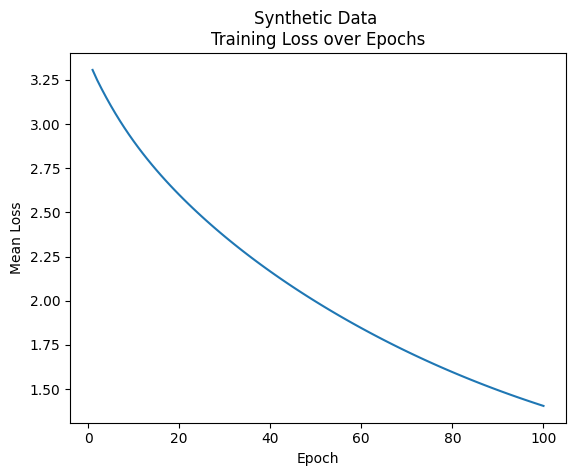

In [30]:
plot_loss(epochs, losses)

# Part D: Training on the Full Data (10 points)

To train on the full data, you are going to need to do some pre-processing of the data.

First, there are no "questions". You need to generate questions for each type of relation. There a number of ways to do this. The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name]. Because there are a lot of different types of relations, you may want to remove the more obscure relations so you need fewer templates and also have a smaller vocabulary. Templates work well if the questions are expected to be almost identical to the templates. You may want to generate multiple templates per relation. Continuing the previous example, a second template would be: "What is the birthdate of [name]?".

If you are feeling more ambitious, you could use GPT-J, GPT-NeoX, GPT-3 or ChatGPT to generate templates. It works decently well and you can get some variety of templates.

The question should contain information about the person and some words that are representative of the relation even if the exact relation words aren't used (the KVMemNet should figure out that "birthdate" and "born" are correlated).

You only put a subset of all key-value pairs into the KVMemNet. You need a technique for sub-selecting from all the key-value pairs in `DB`. You might just need the ones that are directly associated with the person (Alexander Hamilton has 23). You may need to mix in a few key-value pairs from another person's entries in the database to help ensure against accidental overfitting.

The final challenge you will have in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. In that case, you can at least use the values that you sent to the KVMemNet, along with as many other randomly selected values as you can fit into the GPU's memory.

Create as many cells below as you need. Save the output of your training and testing functions, reporting loss during training and accuracy during testing. 5 points for a training loop that reduces loss. 5 points for a training function with a correct accuracy computation.

In [32]:
from collections import Counter
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [33]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## KVMemNet

In [34]:
class KVMemNet(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(KVMemNet, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Define linear projections
        self.A = nn.Linear(vocab_size, embed_dim, bias=False)  # For questions and keys
        self.B = nn.Linear(vocab_size, embed_dim, bias=False)  # For values

    def forward(self, question, keys, values):
        """
        question: (batch_size, vocab_size)
        keys:     (batch_size, num_keys, vocab_size)
        values:   (batch_size, num_values, vocab_size)
        """
        # Project inputs into embedding space
        q = self.A(question)                  # (batch_size, embed_dim)
        k = self.A(keys)                      # (batch_size, num_keys, embed_dim)
        v = self.A(values)                    # (batch_size, num_values, embed_dim)

        # Attention scores: dot product between q and k
        attention_scores = torch.bmm(k, q.unsqueeze(2)).squeeze(2)
        attention_probs = F.softmax(attention_scores, dim=1)            # (batch_size, num_keys)

        # Weighted sum over values
        output = torch.bmm(attention_probs.unsqueeze(1), v).squeeze(1)  # (batch_size, embed_dim)

        return output


## Prepare data


### Reduce Vocabulary

Filter the DB to include only a subset of people -- Limits the number of samples to reduce computational load.

In [35]:
def filter_db_by_person(DB, max_train=500, max_test=100):
    all_people = list(DB.keys())
    train_people = all_people[:max_train]
    test_people = all_people[max_train:max_train+max_test]

    train_db = {p: DB[p] for p in train_people}
    test_db = {p: DB[p] for p in test_people}

    return train_db, test_db


In [36]:
train_db, test_db = filter_db_by_person(DB, max_train=500, max_test=100)

In [115]:
VOCAB2 = make_vocab(train_db)
VOCAB_RED = reduce_vocab(VOCAB2, min_word_occurrence=2)
save_data(path, VOCAB_RED, name="vocab_reduced")

100%|██████████| 37752/37752 [00:00<00:00, 2380637.84it/s]


In [37]:
# VOCAB_RED = load_data(path, name="vocab_reduced")

print("VOCAB size:", VOCAB.num_words())
print("VOCAB_RED size:", VOCAB_RED.num_words())

VOCAB size: 96093
VOCAB_RED size: 2802


### Question generator

1. Extract top relations: find most common relations
2. Define templates for each relation: containing the person's name and words representative of the relation, even if they don’t exactly match.
3. Create function to generate natural language questions: given a person and a relation, returns several questions.

In [38]:
def get_top_relations(DB, top_n=20):
    ignore_keys={'name', 'article_title'}
    relation_counter = Counter()

    for entity in DB.values():
        for key in entity:
            if key not in ignore_keys:
                relation_counter[key] += 1

    return [relation for relation, _ in relation_counter.most_common(top_n)]

In [39]:
def load_template(filepath="question_template.json"):
    with open(filepath, 'r') as f:
        templates = json.load(f)
    return templates


In [211]:
def generate_questions(person_name, person_data, templates, top_relations, num_questions=3):
    """
    Given a person's name, generate up to `num_questions` per relation using templates.
    """
    Qs = []

    for rel in top_relations:
        # get all templates for this relation
        if rel not in person_data:
            continue

        rel_temps = templates.get(rel,  [f"{person_name} {rel.replace('_', ' ')}"])

        # Shuffle and select num_questions templates
        n = min(num_questions, len(rel_temps))
        chosen = random.sample(rel_temps, n)

        # generate questions
        val = person_data[rel]
        for t in chosen:
            question = t.replace("[NAME]", person_name).replace("[RELATION]", rel.replace("_", " "))
            key = f"{person_name} {rel}"
            Qs.append((question, key, val))

    return Qs

In [212]:
# Check top relations
DB = load_data(path, name="data")
print("Top relations:", get_top_relations(DB, top_n=5))

Top relations: ['office', 'term_start', 'birth_date', 'birth_place', 'term_end']


In [213]:
#Check the question template
print("Question templates for 'birth_date':")
load_template().get("birth_date", [])

Question templates for 'birth_date':


['When was [NAME] born?',
 'What is the birth date of [NAME]?',
 "What is [NAME]'s date of birth?",
 "Could you tell me [NAME]'s birthday?"]

In [215]:
# Check the question generation
person = "alexander hamilton"
relation = ["birth_date"]

print("\nGenerated questions for 'birth_date':")
generate_questions(person, DB[person], load_template(), relation, num_questions=3)


Generated questions for 'birth_date':


[('What is the birth date of alexander hamilton?',
  'alexander hamilton birth_date',
  '11 january 1755'),
 ('When was alexander hamilton born?',
  'alexander hamilton birth_date',
  '11 january 1755'),
 ("What is alexander hamilton's date of birth?",
  'alexander hamilton birth_date',
  '11 january 1755')]

### Build Samples as Key-Value Pairs

Prepare: Questions (x), Keys (k), and Values (v) tensors.

For each person, select:
- All their key-value pairs (primary facts)
- Some distractors (random key-value pairs from other people or other relations of the same person)


Steps:
1. Build key-value pairs for each person, filtering by top relations.
2. For each person, generate questions using templates.
3. For each question, create a positive sample (true key-value pair).
4. Generate negative samples (distractors).
5. Encode all key-value options using a multihot encoding.


In [216]:
def build_true_person_kv(DB, top_relations):
    """
    Build a dict {person:[(relation, value)]}, filtering by top relations.
    """
    person_to_kv = {}
    for person, facts in DB.items():
        kv = [(rel, val) for rel, val in facts.items() if rel in top_relations]
        if kv:
            person_to_kv[person] = kv
    return person_to_kv

In [217]:
def build_distractors_diff_person(person_kv_map, exclude_person, num_distractors):
    """
    Returns a list of (key, value) pairs from random other persons.
    """
    all_people = list(person_kv_map.keys())
    distractors = []

    while len(distractors) < num_distractors:
        dist_person = random.choice(all_people)
        if dist_person == exclude_person:
            continue
        dist_kvs = person_kv_map.get(dist_person, [])
        if not dist_kvs:
            continue
        rel, val = random.choice(dist_kvs)
        key = f"{dist_person} {rel.replace('_', ' ')}"
        distractors.append((key, val))

    return distractors


In [218]:
def build_distractors_same_person(person, true_key, person_kv_map, max):
    """
    Get distractor (key, value) pairs from other relations of the same person,
    excluding the correct key. Boosts key with 'relation'.
    """
    distractors = []
    for rel, val in person_kv_map.get(person, []):
        alt_key = f"{person} {rel.replace('_', ' ')}"
        if alt_key != true_key and len(distractors) < max:
            distractors.append((alt_key, val))
    return distractors


In [219]:
def safe_multihot(text, vocab, preserve_counts=False):
    """
    Replace OOV tokens with UNK before calling multihot.
    """
    cleaned = unkit(text, vocab)  # replaces unknown tokens with 'unk'
    return multihot(cleaned, vocab, preserve_counts=preserve_counts)

In [220]:
def build_samples(DB, top_relations, templates, vocab, num_questions=2, num_distractors=3):
    """
    Generate all samples as a list of tuples:
    (question_vec, key_matrix, value_matrix, target_idx)
    """
    person_kv_map = build_true_person_kv(DB, top_relations)
    samples = []

    for person in person_kv_map:
        person_data = DB[person]

        # Generate (question, key, value) triples
        qa_samples = generate_questions(person, person_data, templates, top_relations, num_questions)

        for q, key, true_val in qa_samples:
            # 1. Positive smaple
            k_vec = safe_multihot(key, vocab)
            v_vec = safe_multihot(true_val, vocab)

            # 2. Negative samples: different people and same person
            max_same = num_distractors // 2
            max_diff = num_distractors - max_same

            # Get distractors from other people
            distractor_diff = build_distractors_diff_person(person_kv_map, exclude_person=person, num_distractors=max_diff)

            # Add distractors from the same person
            distractors_same = build_distractors_same_person(person, key, person_kv_map, max_same)


            dist_kvs = distractor_diff + distractors_same

            # 3. Encode all key-value options
            all_keys = [k_vec] + [safe_multihot(k, vocab) for k, _ in dist_kvs]
            all_vals = [v_vec] + [safe_multihot(v, vocab) for _, v in dist_kvs]
            q_vec = safe_multihot(q, vocab)

            samples.append((q_vec, np.stack(all_keys), np.stack(all_vals), 0))  # target = 0

    return samples


### Dataset & DataLoader

In [221]:
def to_tensor(x, dtype=torch.float32):
    """Safely convert a numpy array or tensor to a tensor, avoiding warnings."""
    return x.clone().detach() if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=dtype)

def pad_to_max(seq_list, max_len, dtype=torch.float32):
    """Pads a list of tensors to the same length along dim=0."""
    return torch.stack([
        F.pad(to_tensor(seq, dtype), (0, 0, 0, max_len - len(seq)))
        for seq in seq_list
    ])

def custom_collate_fn(batch):
    """
    Collate function that pads key and value matrices dynamically.
    """
    q_batch, k_batch, v_batch, t_batch = zip(*batch)

    # Questions and targets
    q_tensor = torch.stack([to_tensor(q) for q in q_batch])     # (B, vocab_size)
    t_tensor = torch.tensor(t_batch, dtype=torch.long)          # (B,)

    # Determine max number of keys/values in this batch
    max_k = max(len(k) for k in k_batch)

    # Pad key/value sets per sample to max_k
    max_k = max(len(k) for k in k_batch)
    k_tensor = pad_to_max(k_batch, max_k)                       # (B, max_k, vocab_size)
    v_tensor = pad_to_max(v_batch, max_k)                       # (B, max_k, vocab_size)


    return q_tensor, k_tensor, v_tensor, t_tensor


In [222]:
class KVMemDataset(Dataset):
    def __init__(self, samples):
        """
        samples: List of (question_vec, key_matrix, value_matrix, target_idx)
        """
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        q, k, v, t = self.samples[idx]
        return (
            torch.tensor(q, dtype=torch.float32),              # (vocab_size,)
            torch.tensor(k, dtype=torch.float32),              # (num_keys, vocab_size)
            torch.tensor(v, dtype=torch.float32),              # (num_values, vocab_size)
            torch.tensor(t, dtype=torch.long)                  # scalar index
        )

In [223]:
def build_dataloaders(DB, top_relations, templates, vocab, batch_size=32, num_distractors=3, num_questions=2):

    samples = build_samples(DB, top_relations, templates, vocab, num_questions, num_distractors)

    # Create dataset and dataloader
    dataset = KVMemDataset(samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    return dataloader


## Create datasets

**Create a training dataset and a non-overlapping testing dataset**

If CPU memory becomes a problem you might want to consider a `DataLoader` so that data can be stored on file and pulled up when needed.

In [224]:
# VOCAB_EXP = load_data(path, name="vocab_expanded")

In [225]:
# DATA PARAMETERS
n_relations = 5
n_questions = 4
n_distractors = 15

TRAIN_SAMPLES = 500
TEST_SAMPLES = 100
BATCH_SIZE = 32

In [226]:
## NOTE: commented code already run before

# Prepare
# train_db, test_db = filter_db_by_person(DB, max_train=TRAIN_SAMPLES, max_test=TEST_SAMPLES)
VOCAB_RED = load_data(path, name="vocab_reduced")
top_relations = get_top_relations(train_db, top_n=n_relations)
q_template = load_template("question_template.json")

# Build datasets with distractors
train_loader = build_dataloaders(train_db, top_relations, q_template, VOCAB_RED,
                                 batch_size=BATCH_SIZE,
                                 num_distractors=n_distractors,
                                 num_questions=n_questions)

test_loader = build_dataloaders(test_db, top_relations, q_template, VOCAB_RED,
                                batch_size=BATCH_SIZE,
                                num_distractors=n_distractors,
                                num_questions=n_questions)

In [227]:
print("Train dataset size:", len(train_loader.dataset))
print("Test dataset size:", len(test_loader.dataset))

Train dataset size: 8748
Test dataset size: 1732


In [228]:
# Verify dimensions
batch = next(iter(train_loader))
q, k, v, t = batch

print("Q:", q.shape)  # (batch_size, vocab_size)
print("K:", k.shape)  # (batch_size, num_keys, vocab_size)
print("V:", v.shape)  # (batch_size, num_values, vocab_size)
print("T:", t.shape)  # (batch_size,)

Q: torch.Size([32, 2802])
K: torch.Size([32, 14, 2802])
V: torch.Size([32, 14, 2802])
T: torch.Size([32])


## Training

**Write and run a training loop, showing a loss plot**

You may find it handy to also test your network on the test data periodically as it trains.

In [229]:
import time
def trainModel(model, train_loader, test_loader=None, num_epochs=5, criterion=None, optimizer=None, save_path="model.pt"):
    model.train()
    start_time = time.time()

    train_losses = []
    test_losses  = []
    test_accs    = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for q, k, v, tgt in train_loader:
            q, k, v, tgt = q.to(device), k.to(device), v.to(device), tgt.to(device)

            o = model(q, k, v)                    # (B, E)
            v_emb = model.B(v)                    # (B, M, E)

            scores = torch.bmm(o.unsqueeze(1), v_emb.transpose(1,2)).squeeze(1)
            loss = criterion(scores, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Monitor progress
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"{'='*50}")
        print(f"Epoch {epoch+1:>2}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

        # Evaluate on test data
        if test_loader is not None:
            test_loss, test_acc = evaluateModel(model, test_loader, criterion, device)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            print(f"              Eval Loss: {test_loss:.4f},  Acc: {test_acc:.4%}")

        # Save checkpoint
        torch.save(model.state_dict(), save_path)

    end_time = time.time()

    # Final Test Accuracy
    if test_loader:
        final_loss, final_acc = evaluateModel(model, test_loader, criterion, device)
        print(f"{'='*50}")
        print("\n\n Final Evaluation:")
        print(f"{'-'*50}")
        print(f"Final Test Loss:     {final_loss:.4f}")
        print(f"Final Test Accuracy: {final_acc:.2%}")
        print(f"{'-'*50}\n")

    print(f"Time taken: {end_time-start_time:.2f} sec")
    return train_losses, test_losses, test_accs

In [479]:
def plot_learning_curve(train_losses, test_losses=None, test_accs=None):
    epochs = range(1, len(train_losses) + 1)

    # Plot losses
    plt.plot(epochs, train_losses,  label='Train Loss')
    if test_losses:
        plt.plot(epochs, test_losses,  label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('FULL DATASET\nLearning Curve — Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot test accuracy
    if test_accs:
        #convert to percentage
        test_accs = [acc * 100 for acc in test_accs]
        plt.plot(epochs, test_accs,  label='Test Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('FULL DATASET\nTest Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

## Evaluation

**Write the code for testing your model on the test data**

Your training loop can call the testing loop. But make sure that you do one last test on the model after training completes.

In [231]:
# USE WITH DATALOADER

def evaluateModel(model, test_loader, criterion, device):
    """
    Evaluate the model on the test_loader.

    Args:
        model     : KVMemNet instance
        test_loader: DataLoader for the test set (q, k, v, tgt)
        criterion : loss function (e.g. nn.CrossEntropyLoss())
        device    : torch.device ('cuda' or 'cpu')

    Returns:
        avg_loss  : float, average test loss
        accuracy  : float, fraction of correct predictions
    """
    model.eval()
    total_loss = 0.0
    correct    = 0
    total      = 0

    with torch.no_grad():
        for q_batch, k_batch, v_batch, tgt in test_loader:
            # move to device
            q = q_batch.to(device)       # (B, V)
            k = k_batch.to(device)       # (B, K, V)
            v = v_batch.to(device)       # (B, M, V)
            t = tgt.to(device)           # (B,)

            # forward through A
            o = model(q, k, v)           # (B, E)

            # embed values via B
            v_emb = model.B(v)           # (B, M, E)

            # compute scores and loss
            # scores[b,i] = o[b] · v_emb[b,i]
            scores = torch.bmm(o.unsqueeze(1), v_emb.transpose(1,2)).squeeze(1)  # (B, M)
            loss   = criterion(scores, t)

            # accumulate
            total_loss += loss.item() * q.size(0)
            preds = scores.argmax(dim=1)
            correct += (preds == t).sum().item()
            total   += q.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    model.train()  # back to train mode
    return avg_loss, accuracy


**Run the training loop**

In [232]:
print("VOCAB reduced size:", VOCAB_RED.num_words())

VOCAB reduced size: 2802


In [250]:
# FULL DATA HYPERPARAMETERS
VOCAB_SIZE = VOCAB_RED.num_words()
EMBED_SIZE = 200
# BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 5e-4

In [251]:
model = KVMemNet(VOCAB_SIZE, EMBED_SIZE).to(device)
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.AdamW(model.parameters(),lr=LEARNING_RATE)

In [252]:
print("Training on full data...")

train_losses, test_losses, test_accs = trainModel(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=NUM_EPOCHS,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    save_path="kvmemnet.pt"
)

Training on full data...
Epoch  1/20 | Train Loss: 2.4880
              Eval Loss: 2.1981,  Acc: 28.1755%
Epoch  2/20 | Train Loss: 1.7510
              Eval Loss: 1.6480,  Acc: 57.2748%
Epoch  3/20 | Train Loss: 1.2104
              Eval Loss: 1.4589,  Acc: 62.8176%
Epoch  4/20 | Train Loss: 0.9854
              Eval Loss: 1.3865,  Acc: 65.2425%
Epoch  5/20 | Train Loss: 0.8659
              Eval Loss: 1.3304,  Acc: 68.0716%
Epoch  6/20 | Train Loss: 0.7998
              Eval Loss: 1.3191,  Acc: 68.1293%
Epoch  7/20 | Train Loss: 0.7492
              Eval Loss: 1.3101,  Acc: 69.2263%
Epoch  8/20 | Train Loss: 0.7129
              Eval Loss: 1.3122,  Acc: 69.5150%
Epoch  9/20 | Train Loss: 0.6871
              Eval Loss: 1.3210,  Acc: 70.3233%
Epoch 10/20 | Train Loss: 0.6692
              Eval Loss: 1.3526,  Acc: 69.8037%
Epoch 11/20 | Train Loss: 0.6502
              Eval Loss: 1.3709,  Acc: 70.2656%
Epoch 12/20 | Train Loss: 0.6362
              Eval Loss: 1.3822,  Acc: 69.8037%
Epo

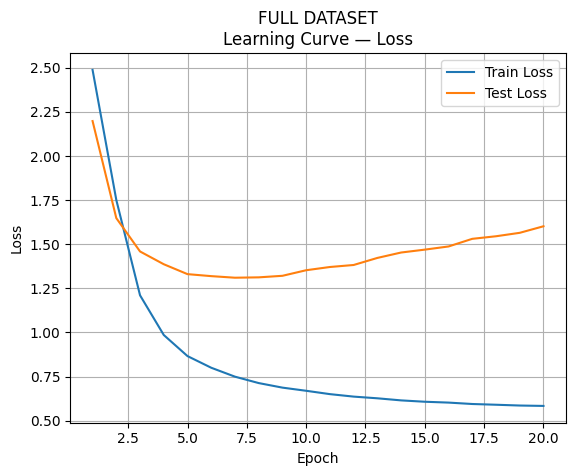

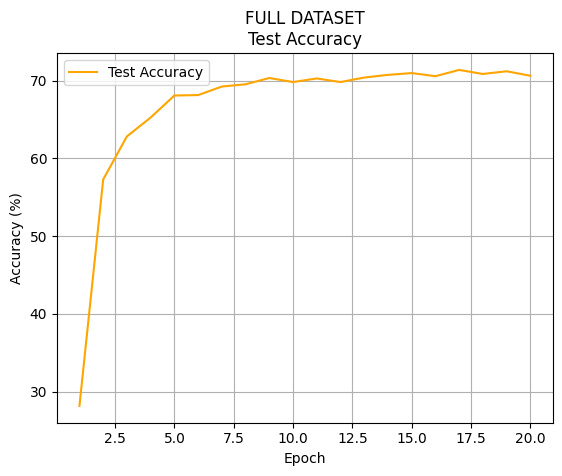

In [481]:
plot_learning_curve(train_losses, test_losses, test_accs)

**Run the evaluation loop**

In [474]:
test_loss, test_acc = evaluateModel(model, test_loader, CRITERION, device)

print("\nModel Evaluation:")
print(f" - Loss: {test_loss:.4f}\n"
      f" - Accuracy: {test_acc:.2%}")


Model Evaluation:
 - Loss: 1.6017
 - Accuracy: 70.61%


**Suggestion:** Once you have a model that has decent accuracy, you may want to save it to your Google Drive using ``torch.save()`` and load it when working on the next part of the assignment using ``torch.load()``.

In [253]:
torch.save(model.state_dict(), "kvmemnet_final.pt")

# load the model
# model = KVMemNet(VOCAB_SIZE, EMBED_SIZE).to(device)
# model.load_state_dict(torch.load("kvmemnet_final.pt"))

------------------

# Part E: Use the Model (5 points)

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, you are asked to create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" Depending on how you pre-proessed your data, you may need to extract the entity and the relation.

Write a function that takes in the `question` below, the data, and the model, and outputs the text answer, e.g., "11 january 1755". You must use your ``KVMemNet``.

**Suggestion:** To process a question you will probably want to find the entity and the relation. You may use packages such as [NLTK](https://www.nltk.org/) (already imported), [SpaCY](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/), or other.

Change the question to test your implementation, but don't delete this cell.

In [ ]:
question = "When was alexander hamilton born?"

**Create your function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

You can create as many cells as necessary. Save the notebook cells showing one example of your input question and output answer. For grading we will look to see that your question is in natural language, the model is used, and the answer is in text. The example doesn't have to be correct. You will analyze your technique later in the report.

### Process question

In [237]:
RELATIONS_SYNONYM_MAP = {
    "birth_date": [
        "birth date", "date of birth", "born", "when was",
        "came into the world", "birthday"
    ],
    "birth_place": [
        "where was", "birthplace", "place of birth", "location was",
        "in which location"
    ],
    "death_date": [
        "death date", "date of death", "when did", "passed away",
        "died", "death"
    ],
    "office": [
        "office", "position", "role", "what office",
        "served in", "official position"
    ],
    "term_start": [
        "term start", "start date", "when did", "began their office",
        "term began", "start their term"
    ],
    "term_end": [
        "term end", "end date", "left office", "term concluded",
        "when did", "term end"
    ]
}


In [348]:
def extract_entity(question: str, DB: dict) -> str:
    q_lower = question.lower()
    candidates = [name for name in DB if name in q_lower]

    if not candidates:
        raise ValueError("extract_entity: No entity found in question.")

    return max(candidates, key=len)

In [349]:
def extract_relation(question: str, synonym_map: dict) -> str:
    q_lower = question.lower()
    for rel, patterns in synonym_map.items():
        for phr in patterns:
            if phr in q_lower:
                return rel
    raise ValueError("extract_relation: No matching relation found in question.")

In [405]:
# def build_kv_context(person, relation, DB):
#     """
#     Select (key, value) pairs only for the relevant person and relation.
#     """
#     facts = DB.get(person, {})
#     kvs = []
#
#     if relation in facts:
#         key = f"{person} {relation.replace('_', ' ')}"
#         val = facts[relation]
#         kvs.append((key, val))
#
#     return kvs

def build_kv_context(person, DB):
    """
    Returns all (key, value) pairs for the person.
    Each key is formed by concatenating the person's name and the relation.
    """
    facts = DB.get(person, {})
    kvs = []

    for relation, val in facts.items():
        # Key becomes: "alexander hamilton birth date"
        key = f"{person} {relation.replace('_', ' ')}"
        kvs.append((key, val))

    return kvs


In [406]:
def select_best_answer(question, kv_pairs, model, vocab):
    # Encode question
    q_vec = torch.tensor(safe_multihot(question, vocab), dtype=torch.float32).unsqueeze(0).to(device)

    # Encode keys and values
    k_vecs = [safe_multihot(k, vocab) for k, _ in kv_pairs]
    v_vecs = [safe_multihot(v, vocab) for _, v in kv_pairs]

    k_tensor = torch.tensor(np.stack(k_vecs), dtype=torch.float32).unsqueeze(0).to(device)
    v_tensor = torch.tensor(np.stack(v_vecs), dtype=torch.float32).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        o = model(q_vec, k_tensor, v_tensor)         # (1, E)
        v_embeds = model.B(v_tensor)                 # (1, K, E)
        scores = F.cosine_similarity(o.unsqueeze(1), v_embeds, dim=-1)  # (1, K)
        best_idx = scores.argmax(dim=1).item()

    return kv_pairs[best_idx][1]  # Return the raw value


In [407]:
def handle_error(e: str) -> str:
    msg = str(e).lower()
    if "extract_entity" in msg:
        return "Error: Entity not present in DB."
    elif "extract_relation" in msg:
        return "Error: Relation not present in DB for given entity."
    else:
        return "Error: An error occurred while processing the question."


In [408]:
def answer_question(question, DB, model, vocab):
    try:
        person = extract_entity(question, DB)
        relation = extract_relation(question, RELATIONS_SYNONYM_MAP)

        kv_candidates = build_kv_context(person, DB)#build_kv_context(person, relation, DB)

        if not kv_candidates:
            return "Error: No entity or relation found in DB."

        answer = select_best_answer(question, kv_candidates, model, vocab)
        return answer

    except Exception as e:
        return handle_error(e)


### Test QA System

#### Correct examples

In [433]:
# Question 1
question = "What is Alexander Hamilton's date of birth?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print("\nExpected:", DB['alexander hamilton']['birth_date'])


Q: What is Alexander Hamilton's date of birth?
A: 11 january 1755

Expected: 11 january 1755


In [415]:
# Question 2
question = "When is jean-marie le pen's birthday?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print("\nExpected:", DB['jean-marie le pen']['birth_date'])


Q: When is jean-marie le pen's birthday?
A: 20 june 1928

Expected: 20 june 1928


In [416]:
# Question 3
question = "What is the birthplace of jean-marie le pen?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print("\nExpected:", DB['jean-marie le pen']['birth_place'])


Q: What is the birthplace of jean-marie le pen?
A: la trinité brittany france

Expected: la trinité brittany france


In [432]:
# Question 4
question = "What office did antonio nariño hold?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print("\nExpected:", DB['antonio nariño']['office'])


Q: What office did antonio nariño hold?
A: vice president of the republic of colombia governor president of the state of cundinamarca governor president of the state of cundinamarca and viceregent of the king person

Expected: vice president of the republic of colombia governor president of the state of cundinamarca governor president of the state of cundinamarca and viceregent of the king person


#### Incorrect examples

In [472]:
# Question 5
question = "When did alexander hamilton die?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print(f"\nExpected: Error")
print("Reason: Relation exists but model was trained on a REDUCED DB with a limited set of relations. "
      "Misidentified relation in the question.")


Q: When did alexander hamilton die?
A: alexander hamilton signaturert

Expected: Error
Reason: Relation exists but model was trained on a REDUCED DB with a limited set of relations. Misidentified relation in the question.


In [467]:
# Question 6
question = "When did jean-marie le pen die?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print(f"\nExpected: Error"
      f"\nReason: Relation does not exist in DB for given entity. Answer given is due to the first matching synonym in the template ('When').")


Q: When did jean-marie le pen die?
A: 20 june 1928

Expected: Error
Reason: Relation does not exist in DB for given entity. Answer given is due to the first matching synonym in the template ('When').


In [468]:
# Question 7
question = "What is jean-marie le pen nationality?"
answer = answer_question(question, DB, model, VOCAB_RED)
print(f"\nQ: {question}\nA: {answer}")
print("\nExpected: Error")
print("Reason: model was trained on a REDUCED DB with a limited set of relations. Unable to match to a relation in the DB.")


Q: What is jean-marie le pen nationality?
A: Error: Relation not present in DB for given entity.

Expected: Error
Reason: model was trained on a REDUCED DB with a limited set of relations. Unable to match to a relation in the DB.


# Part F: Reporting (15 points)

Your report should answer the following three questions:

 **Q1:** What pre-processing of the data did you do? What motivated the design decisions and how did it impact training and any processing of natural language questions (Parts A and D)?

 Hint: This should help one understand any code modifications you made in Parts A and the first part of Part D. But you shouldn't use this to document your code (hopefully you commented your code with code comments and text cells above), but to justify your choices as well as to explain what worked and what didn't work.

 **Q2:** Report on your training on the real data (Part D). Show your loss curve and report on the testing accuracy. There are many ways to implement the training loop, particularly with the choice of keys and values. What decisions did you make when developing your training loop? Justify your decisions. How did they impact the training?

 Hint: This assignment doesn't grade you on how well your model learns---your solution will not be perfect. We focus more on how you worked through the process. This part of the report should show how well your solution worked, but also the intuition for why it works, and to document the things you tried that didn't work.

 **Q3:** Describe your technique on how you process natural language questions (Part E). Provide some examples of your technique answering questions correctly and some examples of your technique answering questions incorrectly. Discuss what causes the failure cases.

 Hint: You are not penalized for incorrectly answered questions---your model will not be perfect---we are looking for honest reflection. Preferably, show the example as code blocks running your model with notebook outputs saved.

 We have provided three prompts below. You can create as many text and code cells as necessary.

---------------------------

## **Q1: Report on Data Pre-processing**

Data Parameters:
- Data Split: 500 train / 100 test
- Top n relations: 5 most frequent relations
- Negative Samples: 15 distractors
- Question Templates: 4 per relation


### Pre-processing Steps

1. **DB reduction by person:**
    We take the full DB and partition it into two non‑overlapping subsets: the first 500 people for training and the next 100 for testing. This keeps memory and compute requirements manageable and ensures that our evaluation set contains only entirely unseen individuals.

2. **Vocabulary reduction:**
    From the training DB we build an initial vocabulary of roughly 96k tokens, then discard any word that appears only once. The resulting reduced vocabulary of about 2800 words makes every multihot vector smaller and faster to process, while also reducing noise from rare words.

3. **Select top relations:**
    We count how often each relation key appears in the training data and select the five most frequent. Concentrating on the most frequent relations ensures the model’s memory is dedicated to the most relevant fact types, speeding up both training and inference.

4. **Question Generation:**
    For each of the five most frequent relations, we produce multiple templated paraphrases—about four unique question strings per person–relation pair, so the model sees different ways to express the same query. In Part E, we expanded this diversity by integrating a synonym map to capture even more linguistic variation.

5. **Negative Sampling (Distractors):**
    - Every true question–key–value triple is augmented with incorrect key–value pairs: half sampled from other people’s facts and half from different relations of the same person. This setup forces the memory network to learn fine‑grained discrimination: distractors drawn from other relations of the same individual force the model to distinguish which fact applies to that person, while distractors from different individuals compel it to recognize the correct person.
    - We then combine the true encoding with its distractors into a single matrix, always placing the correct answer at index 0 as our target for easy retrieval. The distractors are randomly shuffled to prevent the model from simply memorizing their order.
    - Too many distractors (>15) slowed down each batch and lightly hurt accuracy, while fewer than 5 distractors led to overfitting. 15 distractors strikes the right balance, giving the model with a realistic set of plausible alternatives and pushing it to learn precise distinctions.


6. **Key Formatting:**
    During Part E, after observing that the QA system was underperforming, we introduced a natural language formatting step for the keys, converting internal keys such as "alexander hamilton birth_date" into natural phrases like "alexander hamilton birth date". Aligning the key wording with question language improved the model’s ability to compute attention based on overlapping vocabulary.

7. **Encoding & Padding:**
    Questions, keys, and values are each transformed into fixed‑length multihot vectors over the reduced vocabulary, using an UNK fallback for any out‑of‑vocab tokens. At batch time, we zero‑pad each sample’s set of key/value vectors so that every tensor in the batch shares the same shape.

8. **Building the final Datasets:**
    Finally, we wrap all samples in a custom Dataset and DataLoader (batch size 32, 4 questions per person, 15 distractors per question) for both training and testing. This produces approximately 8700 training samples and 1700 test samples as (Q, K, V, target) tensors. By building both sets with the same pipeline, we ensure that evaluation truly mirrors the training setup.

-----------------------------

## **Q2: Report on Training and Testing**


### Model
We used the Key‑Value Memory Network (KVMemNet) architecture as described in the project instructions.
- A shared linear embedding **layer A** for questions, keys, and values
- A separate linear embedding **layer B** for values during final similarity scoring.

All inputs are bag‑of‑words multihot vectors over a reduced vocabulary.


### Hyperparameters
- Batch Size: 32
- Vocabulary Size: Reduced to ~2800 words
- Embedding Size: 200
- Epochs: 20
-
- Learning Rate: 5e-4
- Optimizer: AdamW
- Loss Function: CrossEntropyLoss

Justification:

- **Batch Size (32):** Provides a good balance between stability and memory efficiency. Smaller batches led to noisy updates, while larger batches slowed per‐epoch iteration.
- **Vocabulary Size (~2800):** Reduced from ~96K to focus on the most frequent words. This reduced sparsity and improved convergence speed.
- **Embedding Size (200):** Sufficient capacity for key/value representations without excessive overfitting. Larger sizes led to overfitting and slower training.
- **Epochs (20):** Long enough to observe convergence and early overfitting. We noted test accuracy plateauing around epoch 7–10. Extending to 20 epochs led to overfitting, with test accuracy dropping by the end.
- **Learning Rate (5e-4):** A standard choice for AdamW. Lower rates (1e-4) slowed convergence significantly, while higher rates led to instability.


### Training

We trained the KVMemNet model for 20 epochs on our reduced dataset, using PyTorch’s DataLoader (batch size 32, shuffle=True) to stream mini‑batches of input tensors. Each training step proceeds as follows:

- The question vector and the stacked key/value matrices are passed through the model’s “A” module to produce a fixed‑length embeddings.
- The raw value matrix is then fed to the model’s “B” module to produce a second set of embeddings.
Scoring: We compute dot‐products between the query embedding and each value embedding to produce a similarity score for each key-value pair.
- Loss & Backpropagation: We apply CrossEntropyLoss to these logits with the true index (always 0 in our construction) as the target. Gradients are backpropagated and parameters updated using the AdamW optimizer (learning rate=5e-4).
- After each epoch, we switch the model to eval() mode and measure average loss and accuracy on the held‑out test data.


### Results

- **Training Loss:** fell from ~2.49 → ~0.58 over 20 epochs, confirming the network was fitting the training samples.
- **Test Loss:** dropped to ~1.31 by epoch 7 then gradually rose to ~1.60 by epoch 20, signaling mild overfitting.
- **Test Accuracy:** jumped from 28.2% at epoch 1 to 68.1% by epoch 5, peaked at 71.4% on epoch 17, and finished at 70.6% in the final evaluation.

Final Metrics:
- Average Test Loss: 1.6017
- Final Test Accuracy: 70.61%

### Plots
Loss and accuracy plots (see below).

- **Learning Curves:** the gap between training and test loss begins widening after epoch 7, even as train loss continues to drop indicating overfitting. The model is learning to fit the training data but is not generalizing well enough to unseen data.
- **Test Accuracy:** peaks at epoch 17, then drops slightly by the end. This suggests that the model is learning to generalize but may be overfitting to the training data.


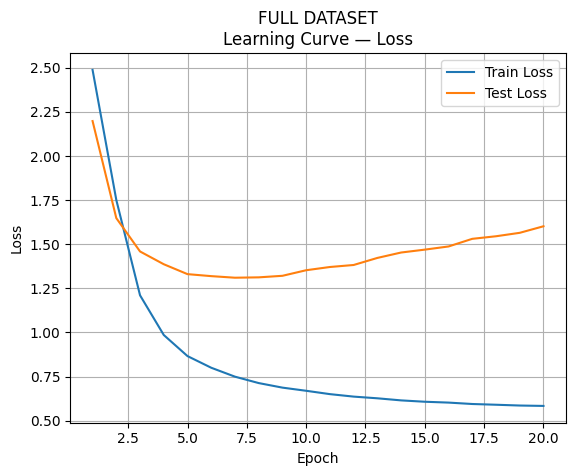

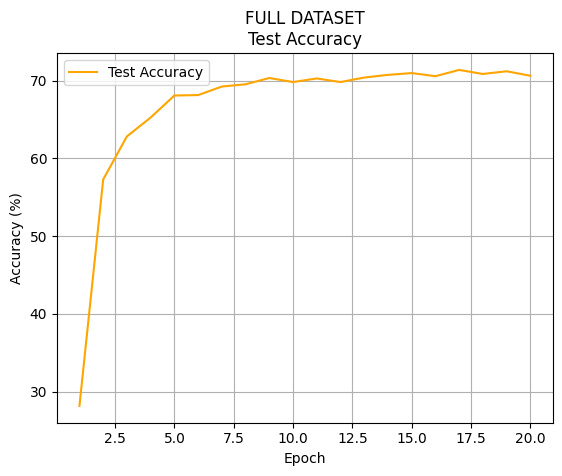

In [480]:
plot_learning_curve(train_losses, test_losses, test_accs)

-------------------------

## **Q3: Report on Model Use**

### **Processing natural language questions**

1. **Extract the entity (person) from the question:**
    we find the longest person name substring present in the reduced DB from all person‑keys. Use a simple name lookup that favors more specific matches so that the longest match handles nested names and avoids false positives (e.g., "alexander hamilton" vs. "alexander").
   However, this approach fails if the question contains a name not in the DB or if the name is misspelled. To solve this, we could extract named entities using  libraries such as SpaCy but opted for a simpler approach for this task.

2. **Extract the relation using a synonym map:**
    we scan each relation’s list of synonym phrases (e.g. "born", "birth date") using a synonym map to match against known relations and return the first matching key. This offers a simple way to handle synonyms and variations in phrasing.
   However, it fails if the question uses a synonym not present in the map or if the relation is not in the DB for that person, or it can even misassign overlapping phrases (e.g.: "when did" may map to term_start instead of term_end depending on which relation comes first.

3. **Buils all key-value data for that person:**
    we retrieve that person’s (key, value) pairs for the requested relation, if it exists, ensuring the model sees a consistent format.

4. **Select the best answer using the trained KVMemNet model and return the value:**
    We trained the network on multihot inputs, so we also encode our inputs before feeding them through the trained KVMemNet. The value whose embedding has the highest cosine score compared to the output is chosen as the answer, since it aligns most closely with the question in the learned space. Finally, we return it as the answer.

### **Correctly Answered Examples**

**Example 1**

    - Question: What is alexander hamilton’s date of birth?
    - Answer: 11 january 1755
    - Expected: 11 january 1755

**Example 2**

    - Question: When is jean‑marie le pen’s birthday?
    - Answer: 20 june 1928
    - Expected: 20 june 1928

**Example 3**

    - Question: What is the birthplace of jean‑marie le pen?
    - Answer: la trinité brittany france
    - Expected: la trinité brittany france

**Example 4**

    - Question: What office did antonio nariño hold?
    - Answer: vice president of the republic of colombia governor president of the state of cundinamarca governor president of the state of cundinamarca and viceregent of the king person
    - Expected: vice president of the republic of colombia governor president of the state of cundinamarca governor president of the state of cundinamarca and viceregent of the king person


These cases work well because the question template closely matches training examples. The model has learned clear associations between words like "date of birth" or "birthday" → birth_date, "birthplace" → birth_place, and "office" → office.

### **Incorrectly Answered Examples**

**Example 5**

    - Question: “When did alexander hamilton die?”
    - Answer: alexander hamilton signaturert
    - Expected: Error

**Example 6**

    - Question: “When did jean‑marie le pen die?”
    - Answer: 20 june 1928
    - Expected: Error

**Example 7**

    - Question: “What is jean‑marie le pen nationality?”
    - Answer: Error: Relation not present in DB for given entity.
    - Expected: Error


These cases fail for several reasons:
- **Synonym ambiguity:** some keywords appear under multiple relations. The simple first‑match strategy may contribute to pick the wrong one (e.g. "when did" matched to birth_date instead of death_date in example 6 or in exmaple 7 the model scores a completely unrelated fact).
- **Reduced relation set:** we only trained on the most frequent relations and ignored other (e.g. "nationality" in example 7). This means that any question about a less common relation will error, even if it exists in the original DB.
- Other failures may be due to a strict substring matching for entities, if the question’s capitalization or minor punctuation differs (“jean-marie le pen’s birthday” vs. "jean-marie le pen").

## **Reflections:**
Overall, the KVMemNet current approach works well with many templated fact questions but breaks when the phrasing or target relation falls outside our manual synonym map or reduced DB. To improve the model’s performance, we could consider entity normalization using a more robust named‐entity recognizer. Also, we could expand the synonym map to include more variations and synonyms for each relation and help the model generalize better by reduce ambiguity in relation extraction. Or we could use a more complex attention mechanism to help the model learn to disambiguate between similar relations (birth_date and birth_place) with contrastive distractors during training.
